# Travaux Pratiques d'imagerie par rayons X
NB : Vous pouvez travailler en groupe mais le travail est à rendre individuellement.

In [1]:
import numpy as np
import xraylib as xrl
from xpecgen import xpecgen as xg
import ipywidgets as widgets
from tabletext import to_text
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tic
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from skimage import io
import scipy.signal

# Exercice 1 - Loi d'atténuation
Le but est de retrouver le coefficient d’atténuation à 100 keV de matériaux à travers une simulation simple mais réaliste en utilisant la loi de Beer-Lambert :
$$
N_{\mathrm{dt}}=N_0\exp(-\mu(E)X)
$$
où $N_0$ est le nombre de photons incident sur l'objet d'épaisseur $X$ et $\mu$ le coefficient d'atténuation linéique à l'énergie $E$.

## Conditions expérimentales
Le code suivant simule un nombre de photons détectés après avoir traversé 0.1 mm de plomb (Pb, densité 11.35 g.cm$^{⁻3}$) et 3.9 cm de polyéthylène (H$_2$C, densité 0.94 g.cm$^{⁻3}$) étant donné un nombre de photons incidents. Le processus stochastique d'atténuation est reproduit (par une loi de probabilité de Poisson).

## Travail demandé

Retrouvez le coefficient d'atténuation du plomb et du polyéthylène à 100 keV avec une précision de $10^{-3}$. Il vous faudra adapter le nombre de photons envoyés. Pour mémoire, la loi de propagation d'erreur d'une fonction $y(x_1, ..., x_N)$ est
$$
\mathrm{Var}[y]=\sum_{i=1}^N\left(\dfrac{\partial y}{\partial x_i}\right)^2\mathrm{Var}[x_i]
$$
où la variance $\mathrm{Var}[]$ représente le carré de l'erreur (ou écart-type).

Vérifiez la concordance du résultat obtenu avec le coefficient d’atténuation linéique théorique obtenu sur la base de données [XCOM](http://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html) de [NIST](http://www.nist.gov/pml/data/xray_gammaray.cfm).

In [2]:
def formula(compound):
    elt_CP = [xrl.AtomicNumberToSymbol(compound['Elements'][i]) for i in range(compound['nElements'])]
    atf_CP = [compound['massFractions'][i]/xrl.AtomicWeight(compound['Elements'][i])
              for i in range(compound['nElements'])]
    atfn_CP = [str(atf/min(atf_CP)) for atf in atf_CP]
    return "".join(np.core.defchararray.add(elt_CP,atfn_CP))

def simulator(N0):
    cpH2C = xrl.GetCompoundDataNISTByName('Polyethylene') 
    dH2C = cpH2C['density']
    fPE = formula(cpH2C)
    NdtH2C = np.random.poisson(N0*np.exp(-3.9*dH2C*xrl.CS_Total_CP(fPE, 100)))
    print('%d photons ont traversé la plaque de 3.9 cm de polyéthylène sur %d envoyés' % (NdtH2C,N0))
    dPb = xrl.ElementDensity(82)
    NdtPb = np.random.poisson(N0*np.exp(-0.01*dPb*xrl.CS_Total(82, 100)))
    print('%d photons ont traversé la plaque de 0.1 mm de plomb sur %d envoyés' % (NdtPb,N0))

widgets.interact_manual(simulator,
                        N0=widgets.IntText(value=100,description="Nombre de photons émis :",disabled=False,
                                           style={'description_width': 'initial'}));

interactive(children=(IntText(value=100, description='Nombre de photons émis :', style=DescriptionStyle(descri…

# Exercice 2 - Étude du polychromatisme

La largeur du spectre en énergie des photons incidents a une forte influence sur la formation de
l’image radiologique. Nous l’étudions ici.

## Conditions expérimentales

Le logiciel de simulation ci-dessous permet de calculer des spectres tels que générés par les générateurs de rayons X en précisant :
- la haute tension U d’accélération des électrons
- l'épaisseur et la nature d'une plaque insérée dans le faisceau 

Certaines grandeurs associées aux spectres sont calculées en sortie notamment
- la couche de demi-atténuation (en mm d’Al),
- l’énergie moyenne des photons du spectre

Nota Bene : caractéristiques du tube X
- réglé pour avoir 1mGy à 1m dans l'air en absence objet
- filtration interne de 1.2mm d'aluminium


## Travail demandé

Nous allons observer l’évolution du spectre en fonction de l’épaisseur et de la nature d'une plaque insérée dans le faisceau. Utilisez les widgets pour sélectionner le matériau et l'épaisseur de la plaque.
- Tracez l'énergie moyenne des photons transmis derrière une plaque en fonction de son épaisseur pour des plaques en cuivre puis en plomb. Quelles sont les valeurs limites ?
- Expliquez la différence entre les deux spectres transmis (plomb vs cuivre) en regardant les coefficients d'atténuation correspondants, disponibles dans la cellule ci-dessous.
- Déterminez pour ce spectre de rayons X de 100 kV les 10 premiers HVL (couche de demi-valeur) exprimés en mm d'aluminium. Expliquez la valeur limite.
- Pour l'ensemble des matériaux proposés dans le menu déroulant, trouvez l'épaisseur de plaque correspondante qui supprime les énergies en dessous de 40 keV. Expliquez les différences. Vérifiez que ce filtre fonctionne également pour d'autres tensions.

In [3]:
def spectrum(E0,Mat_Z,Mat_X):
    xrs=xg.calculate_spectrum(E0,12,3,100,epsrel=0.5,monitor=None,z=74)
    #Inherent filtration: 1.2mm Al + 100cm Air
    mu_Al=xg.get_mu(13)
    xrs.attenuate(0.12,mu_Al)
    xrs.attenuate(100,xg.get_mu("air"))
    fluence_to_dose=xg.get_fluence_to_dose()
    xrs.set_norm(value=0.146,weight=fluence_to_dose)
    #Attenuation
    if Mat_Z>0: #Atomic number
        dMat = xrl.ElementDensity(Mat_Z)
        fMat = xrl.AtomicNumberToSymbol(Mat_Z)
        xrs.attenuate(0.1*Mat_X,xg.get_mu(Mat_Z))
    else: #-1 == 'Water'
        mH2O = 2. * xrl.AtomicWeight(1) + xrl.AtomicWeight(8)
        wH = 0.1 * Mat_X * 2. * xrl.AtomicWeight(1) / (xrl.ElementDensity(1) * mH2O)
        wO = 0.1 * Mat_X * xrl.AtomicWeight(8) / (xrl.ElementDensity(8) * mH2O)
        xrs.attenuate(wH,xg.get_mu(1))
        xrs.attenuate(wO,xg.get_mu(8))
    #Get the figures
    Nr_Photons = "%.4g" % (xrs.get_norm())
    Average_Energy = "%.2f keV" % (xrs.get_norm(lambda x:x)/xrs.get_norm())
    Dose = "%.3g mGy" % (xrs.get_norm(fluence_to_dose))    
    HVL_Al=xrs.hvl(0.5,fluence_to_dose,mu_Al)
    HVL_Al_text = "%.2f mm (Al)" % (10*HVL_Al)
    a = [["Dose à 1m", Dose],["Nombre total de photons", Nr_Photons],
         ["Énergie moyenne des photons",Average_Energy],["Couche de Demie-Atténuation", HVL_Al_text]]
    print(to_text(a))
    (x2,y2) = xrs.get_points()
    plt.figure(1,dpi=150)
    mpl.rcParams.update({'font.size': 6})
    axMW = plt.subplot(111)
    axMW.plot(x2,y2)
    axMW.set_xlim(3,E0)
    axMW.set_ylim(0,)
    plt.xlabel("Énergie [keV]")
    plt.ylabel("Nombre de photons par [keV·cm²·mGy] @ 1m")
    axMW.grid(which='major', axis='x', linewidth=0.5, linestyle='-', color='0.75')
    axMW.grid(which='minor', axis='x', linewidth=0.2, linestyle='-', color='0.85')
    axMW.grid(which='major', axis='y', linewidth=0.5, linestyle='-', color='0.75')
    axMW.grid(which='minor', axis='y', linewidth=0.2, linestyle='-', color='0.85')
    axMW.xaxis.set_major_formatter(tic.FormatStrFormatter("%d"))
    axMW.yaxis.set_major_formatter(tic.FormatStrFormatter("%.2g"))
    axMW.xaxis.set_minor_locator(AutoMinorLocator())
    axMW.yaxis.set_minor_locator(AutoMinorLocator())
    axMW.grid(True)
    plt.show()

widgets.interact_manual(spectrum, 
                E0 = widgets.IntText(value=100,step=1,description="Haute tension (kV) :",disabled=False,
                                     style={'description_width': 'initial'}),
                Mat_Z = widgets.Dropdown(options=[('eau',-1),('aluminium',13),('cuivre',29),('plomb',82)],
                                         value=-1,layout={'width': 'max-content'},description='Matériau :',
                                         style={'description_width': 'initial'}),
                Mat_X = widgets.FloatText(value=0.,step=0.01,description="Épaisseur (mm) :",disabled=False,
                                          style={'description_width': 'initial'}));


interactive(children=(IntText(value=100, description='Haute tension (kV) :', style=DescriptionStyle(descriptio…

# Coefficient d'atténuation linéique
$$
\mu = \sum_{i\in\mathsf{Interactions}} \mu_i = \rho \frac{\mathcal{N}_A}{A} \left(
\sum_{i\in\mathsf{Interactions}}\sigma_i\right)
$$
où $\sigma_i$, qui ne dépend pas de la densité $\rho$, est la section efficace (en cm$^2$) de l'interaction $i$ pour le materiau

In [4]:
def mu(Z=13,components=False):
    energy_range = np.arange(5.,800., 0.1, dtype=np.double)
    density = xrl.ElementDensity(Z)
    mu_rho = [xrl.CS_Total(Z, E) * density for E in energy_range]
    if components:
        mu_rho_Photo = [xrl.CS_Photo(Z, E) * density for E in energy_range]
        mu_rho_Compt = [xrl.CS_Compt(Z, E) * density for E in energy_range]
        mu_rho_Rayl = [xrl.CS_Rayl(Z, E) * density for E in energy_range]
    plt.figure(dpi=150)
    mpl.rcParams.update({'font.size': 6})
    axMW = plt.subplot(111)
    axMW.plot(energy_range, mu_rho,color="black",linewidth=2.,linestyle="-",label='Total')
    if components:
        axMW.plot(energy_range, mu_rho_Photo,color="red",linewidth=2.,linestyle="-",label='Photoelectric')
        axMW.plot(energy_range, mu_rho_Compt,color="blue",linewidth=2.,linestyle="-",label='Compton')
        axMW.plot(energy_range, mu_rho_Rayl,color="green",linewidth=2.,linestyle="-",label='Rayleigh')
    axMW.set_xscale('log')
    axMW.set_yscale('log')
    axMW.set_xlim(np.min(energy_range),np.max(energy_range))
    plt.legend(loc='center right', frameon=True)
    plt.xlabel('Énergie (keV)')
    plt.ylabel("Coefficient d'atténuation linéique (cm$^{-1}$)")
    axMW.grid(which='major', axis='x', linewidth=0.5, linestyle='-', color='0.75')
    axMW.grid(which='minor', axis='x', linewidth=0.3, linestyle='-', color='0.75')
    axMW.grid(which='major', axis='y', linewidth=0.5, linestyle='-', color='0.75')
    axMW.grid(which='minor', axis='y', linewidth=0.3, linestyle='-', color='0.75')
    axMW.xaxis.set_major_formatter(tic.FormatStrFormatter("%d"))
    #axMW.xaxis.set_minor_formatter(tic.FormatStrFormatter("%d"))
    axMW.grid(True)
    symbol=xrl.AtomicNumberToSymbol(Z)
    axMW.set_title("%s" % symbol, va='bottom')
    #plt.savefig('mu_over_rho_W.pdf', format='PDF')
    
    plt.show()

widgets.interact(mu,Z=(1,92,1),components=False,continuous_update=False);

interactive(children=(IntSlider(value=13, description='Z', max=92, min=1), Checkbox(value=False, description='…

# Exercice 3 - Données expérimentales
Il était prévu que vous réalisiez des acquisitions sur le dispositif rayons X suivant :

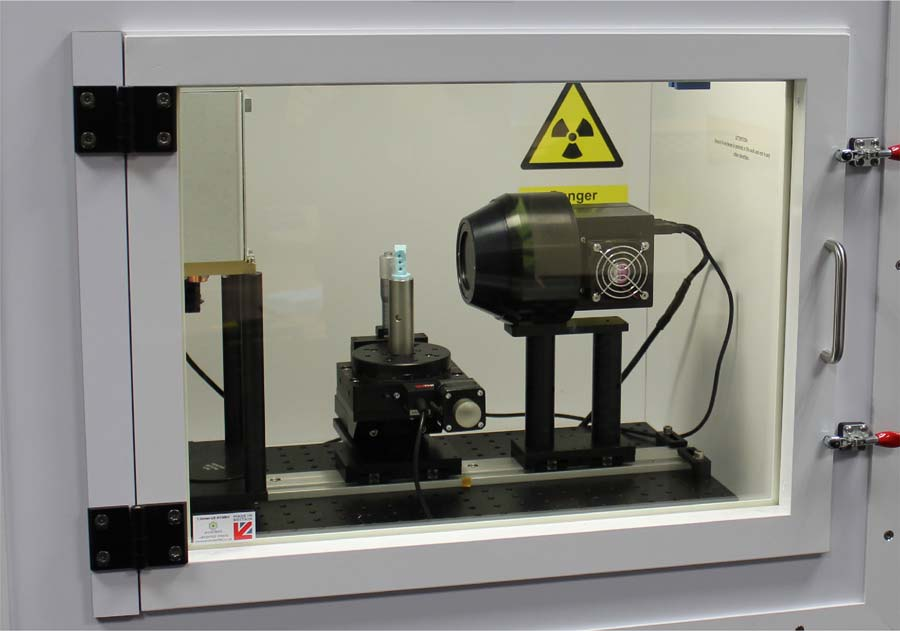

Comme vous ne pourrez pas réaliser ces acquisitions, nous vous fournissons des images acquises l'année dernière.

## Acquisitions sans objet
Dans un premier temps, vous disposez de quatre images acquises sans objet .


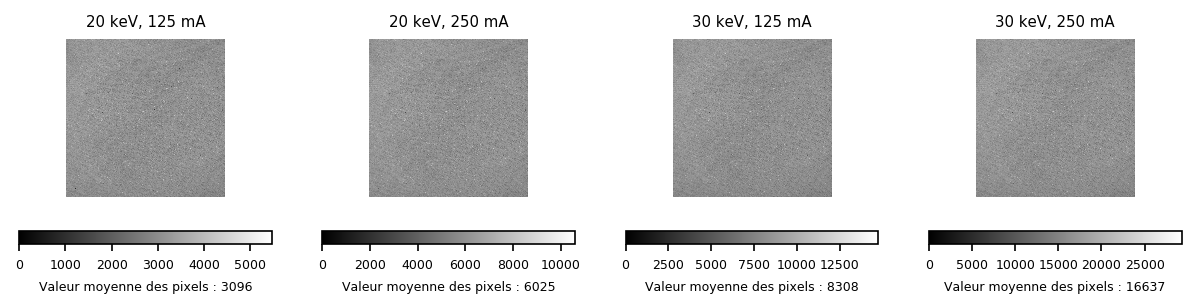

In [22]:
acqui_20_125 = io.imread('images/ss_obj_20KV_12.5.tif')
acqui_20_250 = io.imread('images/ss-obj-20KV_0.25.tif')
acqui_30_125 = io.imread('images/ss-obj_30KV_12.5.tif')
acqui_30_250 = io.imread('images/ss_obj_30_0.25.tif')

plt.figure(figsize=(10,2), dpi=150)
plt.subplot(141)
plt.imshow(acqui_20_125, cmap=plt.cm.gray)
plt.title('20 keV, 125 mA')
plt.colorbar(orientation='horizontal', label='Valeur moyenne des pixels : %d'%(np.mean(acqui_20_125)))
plt.axis('off')
plt.subplot(142)
plt.imshow(acqui_20_250, cmap=plt.cm.gray)
plt.title('20 keV, 250 mA')
plt.colorbar(orientation='horizontal', label='Valeur moyenne des pixels : %d'%(np.mean(acqui_20_250)))
plt.axis('off')
plt.subplot(143)
plt.imshow(acqui_30_125, cmap=plt.cm.gray)
plt.title('30 keV, 125 mA')
plt.colorbar(orientation='horizontal', label='Valeur moyenne des pixels : %d'%(np.mean(acqui_30_125)))
plt.axis('off')
plt.subplot(144)
plt.imshow(acqui_30_250, cmap=plt.cm.gray)
plt.title('30 keV, 250 mA')
plt.colorbar(orientation='horizontal', label='Valeur moyenne des pixels : %d'%(np.mean(acqui_30_250)));
plt.axis('off')

plt.show()

### Travail demandé

À partir des images sans objet, estimez un modèle approximatif donnant la fluence du rayonnement $\Phi$ en fonction de la haute tension $U$ et du courant $I$ sous la forme $\Phi \propto U^a I^b$. Déterminer ces paramètres $a$ et $b$ à partir de la valeur moyenne des pixels dans les images acquises.

## Acquisitions d'un gradin

Dans un second temps, des radiographies d'un gradin d'aluminium ont été acquises. Ce gradin est fait de quatre marches de hauteur 0.5 mm, l'épaisseur maximum étant 2 mm. Les images acquises ont été mises à plat, c'est-à-dire qu'elles ont été divisées par les images sans objet (en reprenant les notations ci-dessus, on a calculé $N_{\mathrm{dt}}/N_0$ en chaque pixel). L'outil ci-dessous calcule la moyenne dans une région d'intérêt qui est affichée en rouge. Le niveau de gris a été ajusté pour qu'on distingue les quatre marches mais vous pouvez le modifier en ajustant `clim`. 

In [23]:
gradin_20 = io.imread('images/gradin_20KV_0.25.tif')
gradin_30 = io.imread('images/gradin_30KV_0.25.tif')

# Binning 8x8 et mise à plat
gradin_20_map = gradin_20.reshape((256,8,256,8)).mean(-1).mean(1) / acqui_20_250.reshape((256,8,256,8)).mean(-1).mean(1) 
gradin_30_map = gradin_20.reshape((256,8,256,8)).mean(-1).mean(1) / acqui_30_250.reshape((256,8,256,8)).mean(-1).mean(1) 

def roi(xinf=64, xsup=192, yinf=64, ysup=192):
    if xinf>xsup:
        xinf, xsup = xsup, xinf
    if yinf>ysup:
        yinf, ysup = ysup, yinf
    plt.figure(figsize=(10,4), dpi=150)
    plt.subplot(121)
    plt.imshow(gradin_20_map, cmap=plt.cm.gray, clim=[0,0.12])
    plt.title('20 keV')
    rect = patches.Rectangle((xinf,yinf),xsup-xinf,ysup-yinf,linewidth=3,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    plt.colorbar(orientation='horizontal', label='Valeur moyenne dans la région : %.4f'%(np.mean(gradin_20_map[yinf:ysup,xinf:xsup])))
    plt.subplot(122)
    plt.imshow(gradin_30_map, cmap=plt.cm.gray, clim=[0,0.04])
    plt.title('30 keV')
    rect = patches.Rectangle((xinf,yinf),xsup-xinf,ysup-yinf,linewidth=3,edgecolor='r',facecolor='none')
    plt.gca().add_patch(rect)
    plt.colorbar(orientation='horizontal', label='Valeur moyenne dans la région : %.4f'%(np.mean(gradin_30_map[yinf:ysup,xinf:xsup])))
    plt.show()

widgets.interact(roi,xinf=(0,255,1),xsup=(0,255,1),yinf=(0,255,1),ysup=(0,255,1),continuous_update=False);

interactive(children=(IntSlider(value=64, description='xinf', max=255), IntSlider(value=192, description='xsup…

### Travail demandé

- Calculez le coefficient d'atténuation de chacune des marches à 20 keV et 30 keV et tracez l'évolution de ce coefficient en fonction de l'indice de la marche.
- À partir de la courbe du coefficient d'atténuation linéaire de l'aluminium, déduisez-en l'énergie effective de chaque marche. Pour faciliter la lecture sur la courbe, vous pourrez réduire l'échelle des énergies de 5 keV à 30 keV en remplaçant 800 par 30 dans le calcul de `energy_range`.

## Étude du diffusé

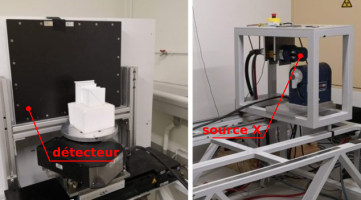

Nous avons fait 3 acquisitions avec avec une source réglée sur 100 kV en tension et 3 mA en courant et un détecteur Varian de 2048 par 1536 pixels de 194 microns. Pour simplifier, nous considérerons que la mesure codée sur 2 octets en chaque pixel fournie par le détecteur est proportionnelle au nombre de photons incidents sur ce pixel. Nous avons pris comme objet quatre plaques de polyéthylène de 5 mm d'épaisseur et arrangées de telle sorte à faire 2 marches de 1 et 2 cm d'épaisseur. Les trois acquisitions sont les suivantes :

1. une image sans objet appelée "Référence 100 kV 3 mA",
2. une image avec les plaques placées contre le détecteur,
3. une image avec les plaques placées à 75 cm du détecteur.

Les acquisitions et des profils horizontaux extraits des images sont présentés ci-dessous. 

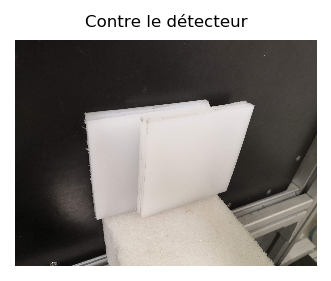

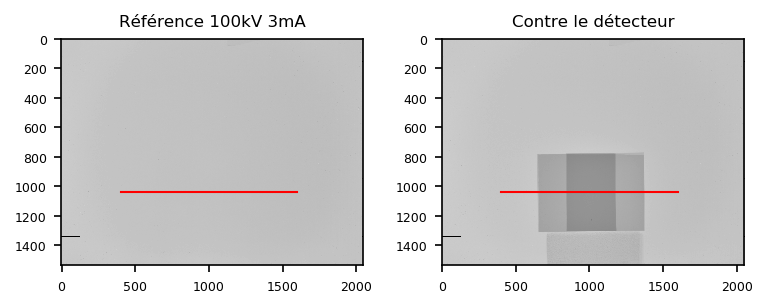

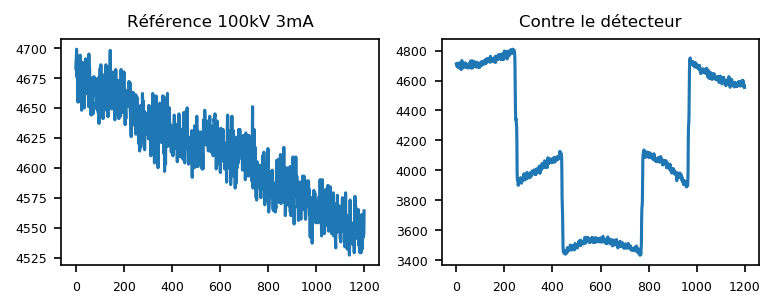

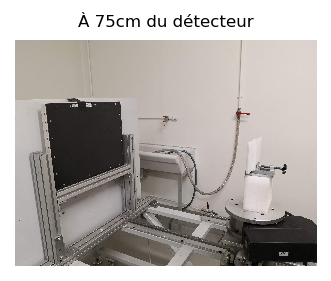

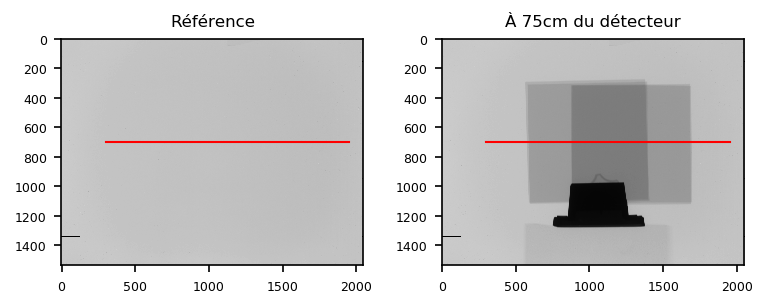

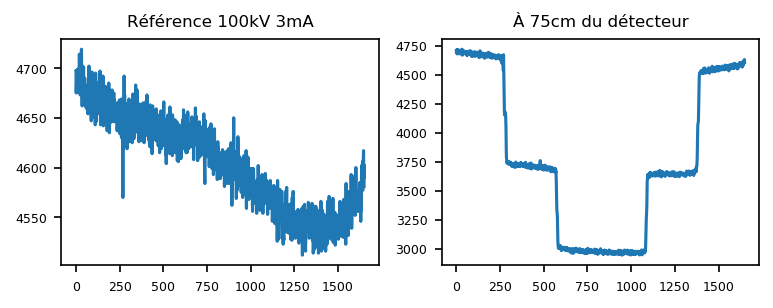

In [63]:
gradinPEclose = io.imread('images/ImagePEclose.jpg')
plt.figure(figsize=(3,2), dpi=150)
plt.subplot(111)
plt.imshow(gradinPEclose)
plt.title('Contre le détecteur', fontsize=8)
plt.axis('off')

xc1 = 400
xc2 = 1600
yc = 1040
xf1 = 300
xf2 = 1950
yf = 696

kVmA = io.imread('images/kV100mA3.tif')
PEclose = io.imread('images/PE0cm_kV100mA3.tif')
PEfar = io.imread('images/PE75cm_kV100mA3.tif')
plt.figure(figsize=(6,2), dpi=150)
plt.subplot(121)
plt.imshow(kVmA, cmap=plt.cm.gray)
plt.title('Référence 100kV 3mA', fontsize=8)
plt.plot([xc1, xc2], [yc, yc], 'r-', lw=1)
plt.subplot(122)
plt.imshow(PEclose, cmap=plt.cm.gray)
plt.title('Contre le détecteur', fontsize=8)
plt.plot([xc1, xc2], [yc, yc], 'r-', lw=1)

plt.figure(figsize=(6,2), dpi=150)
plt.subplot(121)
plt.plot(kVmA[yc,xc1:xc2])
plt.title('Référence 100kV 3mA', fontsize=8)
plt.subplot(122)
plt.plot(PEclose[yc,xc1:xc2])
plt.title('Contre le détecteur', fontsize=8)

gradinPEfar = io.imread('images/ImagePEfar.jpg')
plt.figure(figsize=(3,2), dpi=150)
plt.subplot(111)
plt.imshow(gradinPEfar)
plt.title('À 75cm du détecteur', fontsize=8)
plt.axis('off')

plt.figure(figsize=(6,2), dpi=150)
plt.subplot(121)
plt.imshow(kVmA, cmap=plt.cm.gray)
plt.title('Référence', fontsize=8)
plt.plot([xf1, xf2], [yf, yf], 'r-', lw=1)
plt.subplot(122)
plt.imshow(PEfar, cmap=plt.cm.gray)
plt.title('À 75cm du détecteur', fontsize=8)
plt.plot([xf1, xf2], [yf, yf], 'r-', lw=1)

plt.figure(figsize=(6,2), dpi=150)
plt.subplot(121)
plt.plot(kVmA[yf,xf1:xf2])
plt.title('Référence 100kV 3mA', fontsize=8)
plt.subplot(122)
plt.plot(PEfar[yf,xf1:xf2])
plt.title('À 75cm du détecteur', fontsize=8)


plt.show()


### Travail demandé

- Calculez la distance source-détecteur.
- On définit le SPR en un pixel donné du détecteur comme le rapport entre le nombre de photons issus d'interactions avec les plaques de polyéthylène (PE) sur le nombre de photons directement transmis sans interaction à travers les plaques. Calculez le SPR maximum observé sur 3 zones : celle de l'air, celle de 1 cm de PE et celle de 2cm de PE.